# MDC 018 - Projeto Final

In [23]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_critic = pd.read_csv("train_critic.csv")

test_critic = pd.read_csv("test_critic.csv")

Verificação de balanceamento:

In [24]:
dataset_sentiment_0 = train_critic.loc[train_critic['Sentiment'] == 0]
dataset_sentiment_1 = train_critic.loc[train_critic['Sentiment'] == 1]

In [25]:
dataset_sentiment_1 = dataset_sentiment_1.sample(n=5000, random_state=42)
dataset_sentiment_1

,Show,Sentiment,Review
3712,The White Lotus,1,"Go in expecting a pleasing, intelligent, and w..."
1683,Twin Peaks,1,"Twin Peaks: The Return was ghastly, comic, rom..."
5335,The Essex Serpent,1,If Perry's book is a novel of sensation posing...
44,My Brilliant Friend,1,For those who luxuriated in its first two seas...
5334,Shining Girls,1,"It’s an intriguing watch, and Moss’ patented, ..."
...,...,...,...
6902,Lost,1,"Some of those actors are giving superlative, c..."
4131,Alias Grace,1,The performances are uniformly first-rate...
6193,You,1,"Despite a few dull moments, the show remains p..."
4226,The Act,1,"All the writing was so well done, and each of ..."


In [26]:
train_critic = pd.concat([dataset_sentiment_1, dataset_sentiment_0], ignore_index=True)

# Embaralhar as amostras
train_critic = train_critic.sample(frac=1, random_state=42).reset_index(drop=True)
train_critic

,Show,Sentiment,Review
0,Mad Men,1,The main event tonight is the return of Mad Me...
1,Hannibal,1,The killers on Hannibal are far less intereste...
2,Ozark,1,Powered by solid performances by the ever-reli...
3,Chloe,0,Perhaps the idea was to evoke the haunting eff...
4,Joe vs Carole,0,While Kate McKinnon and John Cameron Mitchell ...
...,...,...,...
6832,Mythic Quest,1,Mythic Quest excels at finding deeper and nast...
6833,Black Mirror,0,The fifth series of Black Mirror is comprised ...
6834,Stranger Things,0,"Stranger Things 4 is a sad, indulgent, at-time..."
6835,Invasion,0,"For all that money, we might have expected mor..."


Ambos conjuntos estão fortemente desbalanceados.

# Predição de sentimento

Conjunto train_critic

In [27]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_critic.dropna(subset=['Review'], inplace=True)

(train_critic_df, val_critic_df) = train_test_split(train_critic, test_size=0.2)
train_critic_df['Sentiment'].value_counts()

Sentiment
1    3981
0    1487
Name: count, dtype: int64

In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_critic['Sentiment'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_critic['Sentiment']
)

class_weights = dict(zip(classes, weights))
class_weights

{np.int64(1): np.float64(0.6836), np.int64(0): np.float64(1.8616557734204793)}

In [29]:
val_critic_texts = val_critic_df["Review"].tolist()
val_critic_labels = val_critic_df["Sentiment"].tolist()

In [30]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = []

    for text in texts:
        result = classifier(text)
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)
    return round(float(balanced_accuracy_score(labels, predictions)),2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

In [31]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score


model_name = "prajjwal1/bert-small"  # Ou outro checkpoint pré-treinado
num_labels = 2  # Número de classes no seu problema

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_critic['Sentiment']  # Altere para acessar os rótulos no seu dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_critic_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_critic_df['Review']), truncation=True, padding=True, max_length=128)

In [33]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [34]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [35]:
training_args = TrainingArguments(
    output_dir="./results_critic_undersample",
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)
train_critic_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_critic_df['Sentiment'])
})

val_critic_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_critic_df['Sentiment'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_critic_dataset,
    eval_dataset=val_critic_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,0.600700,0.513863,0.773722
2,0.431800,0.424676,0.823386
3,0.270400,0.662618,0.812258


TrainOutput(global_step=2052, training_loss=0.4143170808490954, metrics={'train_runtime': 831.831, 'train_samples_per_second': 19.72, 'train_steps_per_second': 2.467, 'total_flos': 92500810806384.0, 'train_loss': 0.4143170808490954, 'epoch': 3.0})

In [36]:
get_balanced_accuracy(model, tokenizer, val_critic_texts, val_critic_labels)

0.82

In [37]:
trainer.evaluate()

{'eval_loss': 0.42467573285102844,
 'eval_balanced_accuracy': 0.8233857565847746,
 'eval_runtime': 12.7132,
 'eval_samples_per_second': 107.605,
 'eval_steps_per_second': 13.451,
 'epoch': 3.0}

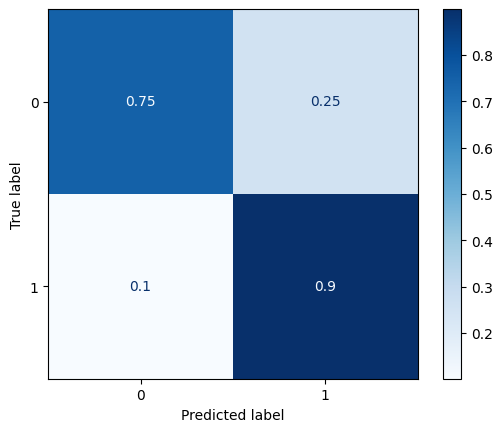

array([[0.747851  , 0.252149  ],
       [0.10107949, 0.89892051]])

In [38]:
plot_confusion_matrix(trainer,val_critic_dataset)

# Teste

In [39]:
test_critic_texts = test_critic["Review"].tolist()
test_critic_labels = test_critic["Sentiment"].tolist()
get_balanced_accuracy(model, tokenizer, test_critic_texts, test_critic_labels)

0.76

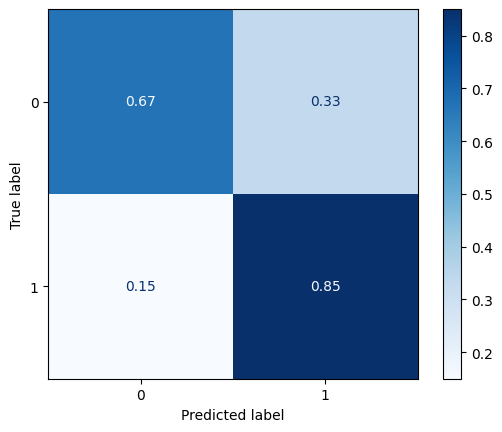

array([[0.66815145, 0.33184855],
       [0.1498008 , 0.8501992 ]])

In [40]:
test_encodings = tokenizer(list(test_critic['Review']), truncation=True, padding=True, max_length=128)
test_critic_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_critic['Sentiment'])
})
plot_confusion_matrix(trainer,test_critic_dataset)